# Pink Floyd Wordcloud

Neste notebook vamos fazer um gráfico com as palavras mais usadas nas músicas do Pink Floyd, e em seguida um wordcloud. 

A banda Pink Floyd foi formado em 1965, na cidade de Londres, Inglaterra, e tem sua fase mais clássica, com a dupla Roger Waters e David Gilmour, até 1983, ano de lançamento do álbum Final Cut.

In [2]:
import pandas as pd
import numpy as np
import re
from os import path
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

# imagens
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# charts
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio
import psutil

# nlp
import nltk
from nltk import sent_tokenize, word_tokenize, tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

#nltk.download('stopwords')
#nltk.download('punkt')

In [3]:
# Carregar dados
df_pink_floyd = pd.read_csv('data/pink_floyd_lyrics.csv', delimiter=',')
df_pink_floyd.head()

,album,song_title,year,lyrics
0,The Piper at the Gates of Dawn,Astronomy Domine,1967-08-05,"""Moon in both [houses]...""...Scorpio, [Arabian..."
1,The Piper at the Gates of Dawn,Lucifer Sam,1967-08-05,"Lucifer Sam, siam cat\nAlways sitting by your ..."
2,The Piper at the Gates of Dawn,Matilda Mother,1967-08-05,There was a king who ruled the land\nHis Majes...
3,The Piper at the Gates of Dawn,Flaming,1967-08-05,Alone in the clouds all blue\nLying on an eide...
4,The Piper at the Gates of Dawn,Pow R. Toc H.,1967-08-05,TCH TCH\nAHH (AHH)\nTCH TCH\nAHH AHH\nDoi doi\...


In [4]:
df_pink_floyd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   album       163 non-null    object
 1   song_title  163 non-null    object
 2   year        163 non-null    object
 3   lyrics      125 non-null    object
dtypes: object(4)
memory usage: 5.2+ KB


<hr />

O dataframe possui 4 colunas:

- **album**: nome do álbum
- **song_title**: nome da música
- **year**: data de lançamento
- **lyrics**: letra da música

O dataframe possui 163 registros, mas alguns deles tem a coluna lyrics vazias, e isso pode ser falta de informação, ou mesmo músicas instrumentais. As demais colunas não tem registros vazios.

### Tratando os dados

In [5]:
# Primeiro vamos converter a coluna year em um formato de data e em seguida excluir a coluna year
df_pink_floyd['date'] = pd.to_datetime(df_pink_floyd['year'])
df_pink_floyd.drop(['year'], axis=1, inplace=True)

Esse dataframe foi baixado do kaggle, então vamos nos certificar dos álbuns que estão contidos no arquivo.

In [6]:
df_pink_floyd['album'].unique()

array(['The Piper at the Gates of Dawn', 'A Saucerful of Secrets',
       'More (Original Film Soundtrack)', 'Ummagumma',
       'Atom Heart Mother', 'Meddle', 'Obscured By Clouds',
       'The Dark Side of the Moon', 'Wish You Were Here', 'Animals',
       'The Wall', 'The Final Cut', 'A Momentary Lapse of Reason',
       'The Division Bell', 'The Endless River'], dtype=object)

Os últimos três álbuns desse array foram lançados depois da fase clássica (até 1983), e por que a análise é apenas desta fase, vamos retirá-los.

*E não é por uma questão de gosto, porque eu gosto bastante do Division Bell.*

In [7]:
# Recria o dataframe cujas datas são menores que 01/01/1984, ou seja, do Final Cut para trás
df_pink_floyd = df_pink_floyd[df_pink_floyd['date'].dt.date < datetime.date(1984, 1, 1)]
df_pink_floyd

,album,song_title,lyrics,date
0,The Piper at the Gates of Dawn,Astronomy Domine,"""Moon in both [houses]...""...Scorpio, [Arabian...",1967-08-05
1,The Piper at the Gates of Dawn,Lucifer Sam,"Lucifer Sam, siam cat\nAlways sitting by your ...",1967-08-05
2,The Piper at the Gates of Dawn,Matilda Mother,There was a king who ruled the land\nHis Majes...,1967-08-05
3,The Piper at the Gates of Dawn,Flaming,Alone in the clouds all blue\nLying on an eide...,1967-08-05
4,The Piper at the Gates of Dawn,Pow R. Toc H.,TCH TCH\nAHH (AHH)\nTCH TCH\nAHH AHH\nDoi doi\...,1967-08-05
...,...,...,...,...
115,The Final Cut,The Fletcher Memorial Home,Take all your overgrown infants away somewhere...,1983-03-21
116,The Final Cut,Southampton Dock,They disembarked in 45\nAnd no - one spoke and...,1983-03-21
117,The Final Cut,The Final Cut,Through the fish - eyed lens of tear stained e...,1983-03-21
118,The Final Cut,Not Now John,"Fuck all that, we've got to get on with these\...",1983-03-21


In [8]:
df_pink_floyd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   album       120 non-null    object        
 1   song_title  120 non-null    object        
 2   lyrics      104 non-null    object        
 3   date        120 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 4.7+ KB


In [9]:
df_pink_floyd[df_pink_floyd['lyrics'].isnull()] # Ver missing values

,album,song_title,lyrics,date
6,The Piper at the Gates of Dawn,Interstellar Overdrive,NaN,1967-08-05
16,A Saucerful of Secrets,A Saucerful of Secrets,NaN,1968-06-29
19,More (Original Film Soundtrack),Party Sequence,NaN,1969-06-13
20,More (Original Film Soundtrack),Main Theme,NaN,1969-06-13
21,More (Original Film Soundtrack),More Blues,NaN,1969-06-13
22,More (Original Film Soundtrack),Quicksilver,NaN,1969-06-13
23,More (Original Film Soundtrack),Dramatic Theme,NaN,1969-06-13
27,More (Original Film Soundtrack),Up The Khyber,NaN,1969-06-13
35,Ummagumma,A Saucerful of Secrets,NaN,1968-06-29
36,Ummagumma,Sysyphus,NaN,1969-10-25


Ainda existem alguns registros com a coluna `lyrics` vazia, mas até onde sei, estes sons são todos instrumentais, então está tudo certo.

### Tratando as palavras

Primeiro vamos setar o tokenizer, o stop words e o stemmer, e mais algumas funções que serão comuns para todas as análises.

In [10]:
tokenizer = tokenize.RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

Como eu já chequei o resultado do gráfico, sei que algumas palavras que estão lá não fazem muito sentido serem usadas, como as onomatopéias, interjeições ou mesmo modais de tempo (will, would), de forma que vou adicioná-las ao stop words.

In [11]:
stop_words.update(['ooh', 'oh', 'ah', 'pa', 'will', 'would'])

A função `count_words` vai receber a coluna text do dataframe, fará os tratamentos das palavras necessárias e retornará as palavras mais frequentes e suas frequências. 

Logo em seguida jogaremos na função `most_freq_words_chart` que plotará os resultados num gráfico.

A função `clean_text` será usada para filtrar as stop words para serem usadas no word cloud.

In [22]:
def count_words(matrix, most_common = 20):
    """
    Args:
        matrix(DataFrame): Recebe uma matriz com os textos
        most_common (int): A quantidade de palavras mais comuns 
        
    Returns:
        words_g (list): retorna todas as palavras do texto
        words (list): as palavras mais frequentes
        values (list): os valores das frequências
    """
    words_g = []
    for lyric in matrix:
        for word in tokenizer.tokenize(lyric): # separa as palavras de cada música
            word = word.lower() #  convertenda a palavra para minúsculo
            if not word in stop_words: # se não for uma 'stop word' será atribuída a variável words_g
                words_g.append(word) # adiciona a palavra para o array
    f = nltk.FreqDist(words_g) # Conta a frequência das palavras dentro do texto
    words = []
    values = []
    for word, value in f.most_common(most_common): # retorna as N palavras mais frequentes no texto
        words.append(word) # recebe a palavra
        values.append(value) # recebe o valor (frequência)
    return words_g, words, values # retorna as palavras, as palavras mais frequentes e o valor da frequência

def most_freq_words_chart(f_words, f_values):
    """
    Args:
        f_words: palavras mais frequentes
        f_values: frequências das palavras
        
    Returns:
        plot: gráfico com as palavras mais frequentes
    """
    plot = go.Figure(
        go.Bar(x = f_words, y = f_values, marker_color=(['orange'] * 4) + (['#cc6600'] * 4) + (['#b35900'] * 4) + (['#994d00'] * 4) + (['#804000'] * 4))
    )
    plot.update_layout(title='Palavras mais frequentes')
    plot.show()
    pio.write_image(plot, "assets/plotly_chart.png", width=600, height=350, scale=2)
    
def clean_text(stop_words, df_text):
    text = " ".join(x.lower().strip() for x in df_text) # pegar as palavras da lista e jogar na string. Limpar os espaços e torná-las minusculas
    clean_text = [word for word in text.split() if word not in stop_words] # Limpar as stop words
    text = ' '.join([str(elem) for elem in clean_text]) # Converter a lista em string
    return text

## Palavras mais frequentes

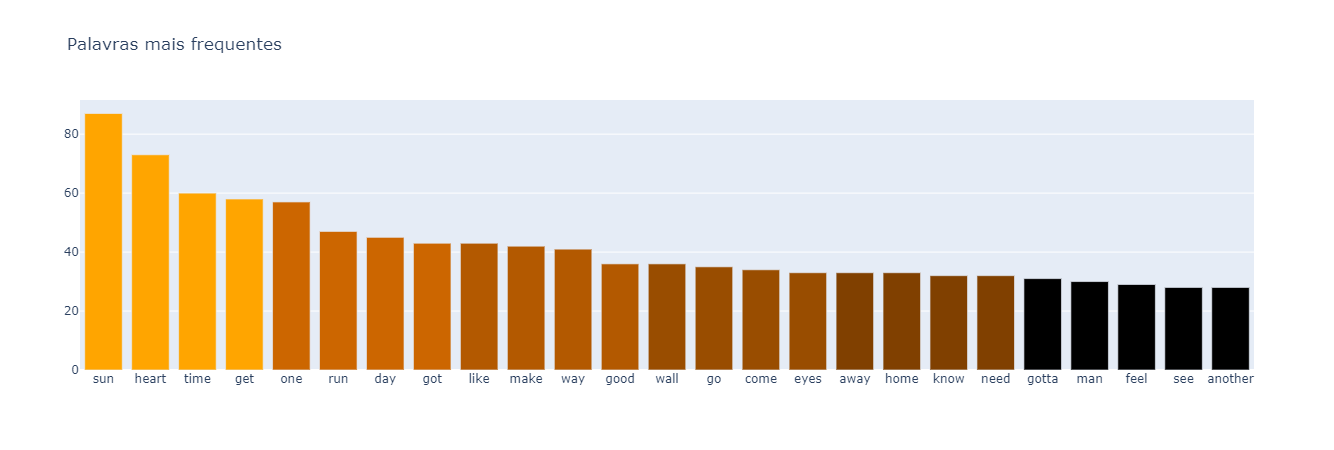

In [23]:
# Vamos inserir a coluna lyrics, filtrando apenas os dados preenchidos
words_g, freq_words, freq_values = count_words(
    df_pink_floyd[df_pink_floyd['lyrics'].notnull()]['lyrics'].values, 25
)
most_freq_words_chart(freq_words, freq_values)

<img src="assets/plotly_chart.png" width="700" height="350" />

## Nuvem de palavras

In [ ]:
# Limpando as palavras para serem usadas pelo wordcloud
words_final = clean_text(stop_words, df_pink_floyd[df_pink_floyd['lyrics'].notnull()]['lyrics'].values)

In [ ]:
wordcloud = WordCloud(
    collocations = False,
    #max_font_size = 50, 
    stopwords = stop_words, 
    background_color="black",
    width=1200, 
    height=700,
    random_state=42,
    ).generate(words_final)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("assets/pink_floyd_cloudwords_generated.png")

<img src="assets/pink_floyd_cloudwords_generated.png" />

Agora vamos aplicar essa wordcloud nessa imagem abaixo, que contém os membros da banda, na seguinte ordem: Roger Waters, Nick Mason, David Gilmour e Richard Wright (imagem de 1971).

<img src="assets/pinkfloydband.jpg" width="300" height="200" />

In [ ]:
prism_mask = np.array(Image.open("assets/pinkfloydband.jpg"))
wc = WordCloud(stopwords= stop_words,
               mask= prism_mask, #background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width= prism_mask.shape[1],
               height= prism_mask.shape[0])
wc.generate(words_final)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()
wc.to_file("assets/pink_floyd_cloudwords_generated_mask.png")

<img src="assets/pink_floyd_cloudwords_generated_mask.png" />

### Referências

- [Kaggle - Pink Floyd Lyrics](https://www.kaggle.com/joaorobson/pink-floyd-lyrics)
- [Wikipedia - Pink Floyd](https://pt.wikipedia.org/wiki/Pink_Floyd)
- [Nb Viewer](https://nbviewer.jupyter.org/)

#### Info

O github renderiza as páginas estaticamente, e por isso não mostra os gráfico do plotly (por isso adicionei uma imagem).

Para visualizar e interagir com o gráfico basta acessar o link:

https://nbviewer.jupyter.org/github/heavyrick/datascience/blob/master/analises/pink_floyd_wordcloud/pink_floyd_wordcloud.ipynb